# Test case LVV-T1074-b: Sky Brightness precision

> **The maximum error in the precision of the sky brightness determination shall be less than SBPerc = 1 percent.**

This test verifies the following requirements:

- LSR-REQ-0093-V-07: Sky brightness determination (https://rubinobs.atlassian.net/browse/LVV-9800)
- OSS-REQ-0387-V-05: Sky Brightness precision (https://rubinobs.atlassian.net/browse/LVV-13366)


#### Discussion

From LVV-9800:

> On real data: run DM stack on images in a variety of conditions, which determines a polynomial fit for the sky, compare the actual sky measurement at points not on the polynomial grid and check that they agree to 1 percent.

Our interpretation of this suggestion in this notebook is to compare the flux values in "empty" regions of the sky using sky objects against the fitted background polynomial model produced by the LSST Science Pipelines.

This test notebook can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team.

Initial testing of this notebook was performed using data in the following collections:

- ComCam: `LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666`
- HSC RC2: `HSC/runs/RC2/w_2024_46/DM-47577`


In [1]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from lsst.afw.geom import SpanSet
from lsst.daf.butler import Butler
from lsst.utils.packages import getEnvironmentPackages
from tqdm import tqdm, trange


def print_session_info():
    # Time info
    print(f"# Session Info on {time.strftime('%Y-%m-%d at %H:%M:%S %Z', time.localtime(time.time()))}\n")

    # Python info
    print(f"## Python Interpreter\n\nVersion: {sys.version}  \nExecutable: {sys.executable}\n")

    # LSST info
    packages = getEnvironmentPackages(True)
    dev_packages = {"lsst_distrib": packages["lsst_distrib"]}
    dev_packages.update({k: v.split("@")[0] for k, v in packages.items() if "LOCAL" in v})
    print("## Science Pipelines\n\n" + "\n".join(f"{k:<20} {v}" for k, v in dev_packages.items()))


print_session_info()

# Session Info on 2025-03-07 at 12:47:58 PST

## Python Interpreter

Version: 3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]  
Executable: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/bin/python

## Science Pipelines

lsst_distrib         gc675d380bf+0eed4878f0 (w_2025_08)


In [2]:
# Choose a data collection
collection = "LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666"
# collection = "HSC/runs/RC2/w_2024_46/DM-47577"

In [3]:
# Instantiate the Butler
repo = "/repo/main"
butler = Butler.from_config(repo, collections=collection)

In [4]:
# Define a visit list
instrument = collection.split("/")[0]
if instrument == "LSSTComCam":
    detectors = list(range(9))
elif instrument == "HSC":
    detectors = list(range(104))
    detectors.remove(9)  # Faulty CCD in HSC
refs = butler.query_datasets("sourceTable_visit", collections=collection)
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]  # g-band only
visits = visits[: int(np.ceil(50 / len(detectors)))]  # limit to a sub-sample of visits

In [5]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

In [6]:
print(f"{repo = }\n{collection = }\n{len(visits) = }")

repo = '/repo/main'
collection = 'LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666'
len(visits) = 6


#### Functions

The cells below define functions that retrieve image, background, and metadata (`retrieveImageAndBackground`) and retrieve sky sources (`retrieveSkySources`).


In [7]:
def retrieveImageAndBackground(dataId, collection):
    """Retrieve the sky-subtracted calibrated exposure and associated metadata.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it, converted to nJy
    background : `ImageF`
        calexpBackground image, converted to nJy
    `metaData` : `dict`
        Dictionary of calexp metadata, including mean BG flux (in nJy)
    """
    # Retrieve the image, metadata, and calibration
    calexp = butler.get("calexp", dataId=dataId, collections=collection)
    background = butler.get("calexpBackground", dataId=dataId, collections=collection)
    metaData = calexp.info.getMetadata().toDict()
    photoZp = calexp.getPhotoCalib().instFluxToNanojansky(1)

    # Convert everything to nanojansky
    calexp.image.array *= photoZp
    backgroundImage = background.getImage().array
    backgroundImage *= photoZp
    metaData["BGMEAN"] *= photoZp
    metaData["BGVAR"] *= photoZp

    return calexp, backgroundImage, metaData

In [8]:
def retrieveSkySources(dataId, collection, aper=9):
    """Retrieve sky source aperture fluxes for a given detector / visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky source aperture radius. Valid are 3,6,9,12,25,35,70.
        The 9 pixel aperture is recommended as sky sources are defined as being
        >8px from the nearest detection.

    Returns
    -------
    x : `numpy.ndarray`
        X pixel coordinates of sky sources.
    y : `numpy.ndarray`
        Y pixel coordinates of sky sources.
    skySourceFlux : `numpy.ndarray`
        Mean fluxes of sky sources within circular aperture of radius aper.
        Units are nJy.
    """
    # Retrieve table
    srcTab = butler.get("sourceTable", dataId=dataId, collections=collection)
    isSky = srcTab["sky_source"] > 0  # Pick only sky sources
    skySources = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already
    nPix = np.pi * aper**2  # Number of pixels per aperture

    return np.array(srcTab[isSky]["x"]), np.array(srcTab[isSky]["y"]), np.array(skySources / nPix)

In [9]:
def getMeanImageValueInAperInd(image, x, y, aper):
    """Compute the mean image values at a given pixel location within a
    circular aperture.

    Parameters
    ----------
    image : array-like
        Image from which to extract the mean value (e.g., a calexp or a
        background image)
    x : int
        X pixel coordinate (row) of the center of the aperture
    y : int
        Y pixel coordinate (column) of the center of the aperture
    aper : int
        Radius of the circular aperture in pixels

    Returns
    -------
    meanFluxInAper : float
        Mean flux within the aperture, computed using the actual number of
        pixels inside the aperture
    """
    # Ensure x and y are integers and background is a numpy array
    x, y = int(x), int(y)
    if hasattr(image, "image"):
        background = image.image.array
    elif hasattr(image, "getImage"):
        background = image.getImage().array
    elif isinstance(image, np.ndarray):
        background = image
    else:
        raise ValueError(f"Input image is not a valid type: {type(image)}")
    rows, cols = background.shape

    # Create grid arrays for the entire image using ogrid (memory efficient)
    X, Y = np.ogrid[:rows, :cols]

    # Create mask for points within the circle (distance from (x, y) <= aper)
    mask = ((X - x) ** 2 + (Y - y) ** 2) <= aper**2

    # Compute the mean using the actual number of pixels within the mask
    nPix = np.sum(mask)

    # 9 pixel aperture has 253 pixels if unmasked, so we scale area accordingly
    nAperPixels = int(np.sum(SpanSet.fromShape(int(aper)).asArray()))  # 253
    area = nPix / nAperPixels * np.pi * aper**2

    # There are some sky sources that are out of bounds, return 0 in this case
    if nPix == 0:
        meanFluxInAper = 0
    else:
        meanFluxInAper = background[mask].sum() / area

    return meanFluxInAper

In [10]:
def getMeanImageAndBackgroundInAper(calexp, backgroundImage, xSeries, ySeries, aper):
    """Compute the mean background at a given pixel location within a circular
    aperture for a location list."""
    meanBackgroundFluxInAperList = []
    meanImageFluxInAperList = []

    for x, y in zip(xSeries, ySeries):
        meanImageFluxInAper = getMeanImageValueInAperInd(calexp, x, y, aper)
        meanBackgroundFluxeInAper = getMeanImageValueInAperInd(backgroundImage, x, y, aper)
        meanBackgroundFluxInAperList.append(meanBackgroundFluxeInAper)
        meanImageFluxInAperList.append(meanImageFluxInAper)
    return np.array(meanImageFluxInAperList), np.array(meanBackgroundFluxInAperList)

In [11]:
def computeSBRatio(dataId):
    """Compute the signal-to-background ratio for a given detector / visit."""
    calexp, background, metaData = retrieveImageAndBackground(dataId, collection)
    xSky, ySky, meanFluxInSky = retrieveSkySources(dataId, collection, aper=9)
    meanImageFluxInAper, meanBackgroundFluxInAper = getMeanImageAndBackgroundInAper(
        calexp, background, xSky, ySky, aper=9
    )

    if len(meanFluxInSky) == 0:
        return None

    # Compute SBPrec ratio
    # Mask out all background aperture values that are zero
    zeroMask = meanBackgroundFluxInAper == 0
    # The sky source flux is background subtracted, so we need to add the background back in
    SBRatio = (meanBackgroundFluxInAper[~zeroMask] + meanFluxInSky[~zeroMask]) / meanBackgroundFluxInAper[
        ~zeroMask
    ]

    return (
        calexp,
        background,
        meanImageFluxInAper,
        meanBackgroundFluxInAper,
        xSky,
        ySky,
        meanFluxInSky,
        SBRatio,
    )

In [12]:
def processVisit(visit):
    """Process a single visit across all detectors."""

    results = {
        "visit": visit,
        "SBRatio": [],
        "SBPerc": [],
        "calexp": [],
        "backgroundImage": [],
        "xSky": [],
        "ySky": [],
        "meanBackgroundInAper": [],
        "meanImageFluxInAper": [],
        "meanFluxInSky": [],
    }

    for det in detectors:
        dataId = {"visit": visit, "detector": det, "instrument": "LSSTComCam"}

        result = computeSBRatio(dataId)
        if result is not None:
            (
                calexp,
                backgroundImage,
                meanImageFluxInAper,
                meanBackgroundInAper,
                xSky,
                ySky,
                meanFluxInSky,
                SBRatio,
            ) = result

            results["calexp"].append(calexp)
            results["backgroundImage"].append(backgroundImage)
            results["xSky"].append(xSky)
            results["ySky"].append(ySky)
            results["meanImageFluxInAper"].append(meanImageFluxInAper)
            results["meanBackgroundInAper"].append(meanBackgroundInAper)
            results["meanFluxInSky"].append(meanFluxInSky)
            results["SBRatio"].append(SBRatio)

    return results

In [13]:
# Calculate the SBRatio for each visit
resultList = []
for visit in tqdm(visits):
    resultList.append(processVisit(visit))

100%|██████████| 6/6 [08:34<00:00, 85.71s/it]


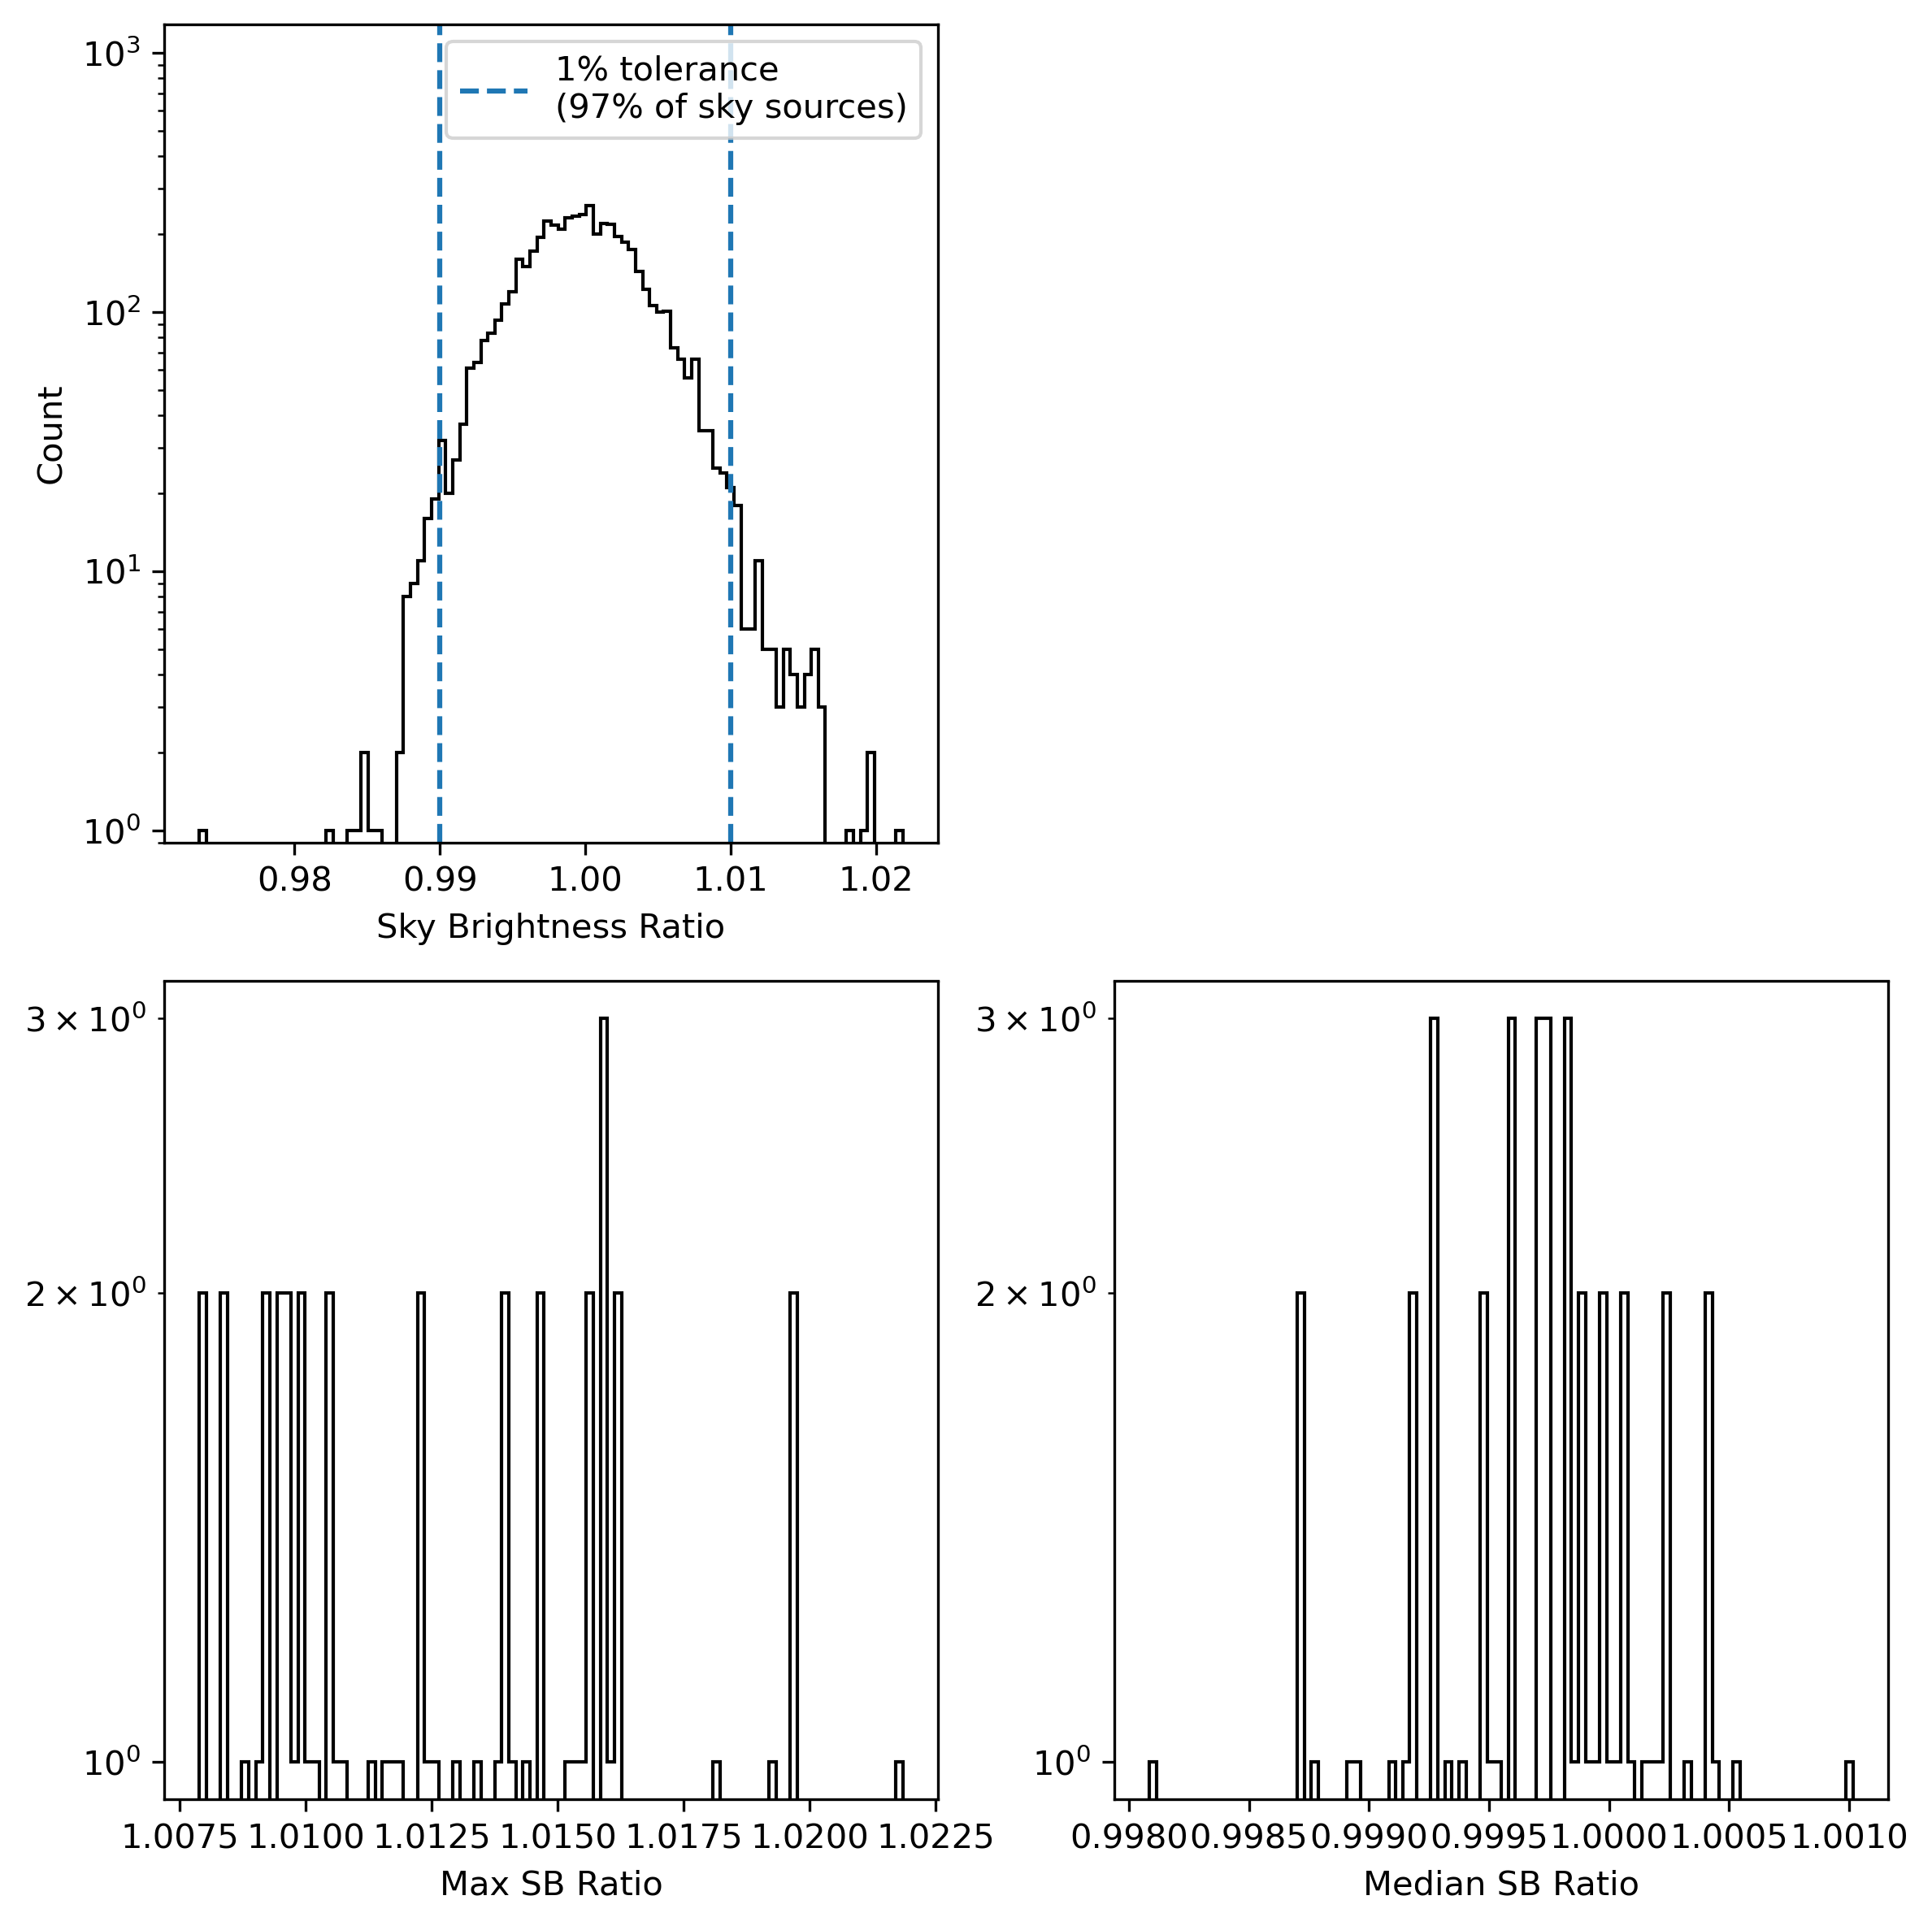

In [14]:
def plotSBRatio(resultList):
    """Plot the SBRatios visit."""
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
    axes = axes.flatten()
    allSBRatio = np.concatenate([np.concatenate(res["SBRatio"]) for res in resultList])
    frac_within_1pc = np.sum((allSBRatio >= 0.99) & (allSBRatio <= 1.01)) / len(allSBRatio)
    maxSBRatio = np.array([np.max(res["SBRatio"][det]) for res in resultList for det in range(9)])
    medianSBRatio = np.array([np.median(res["SBRatio"][det]) for res in resultList for det in range(9)])

    counts, bins, _ = axes[0].hist(allSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[0].set_xlabel("Sky Brightness Ratio")
    axes[0].set_ylabel("Count")
    axes[0].axvline(1.01, linestyle="--")
    axes[0].axvline(0.99, linestyle="--", label=f"1% tolerance\n({frac_within_1pc*100:.0f}% of sky sources)")
    axes[0].legend()
    max_count = np.max(counts)
    axes[0].set_ylim(0.9, max_count * 5)

    axes[1].axis("off")

    axes[2].hist(maxSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[2].set_xlabel("Max SB Ratio")

    axes[3].hist(medianSBRatio, bins=100, histtype="step", color="k", log=True)
    axes[3].set_xlabel("Median SB Ratio")

    plt.tight_layout()
    plt.show()


plotSBRatio(resultList)

High SB Ratio: 0.0


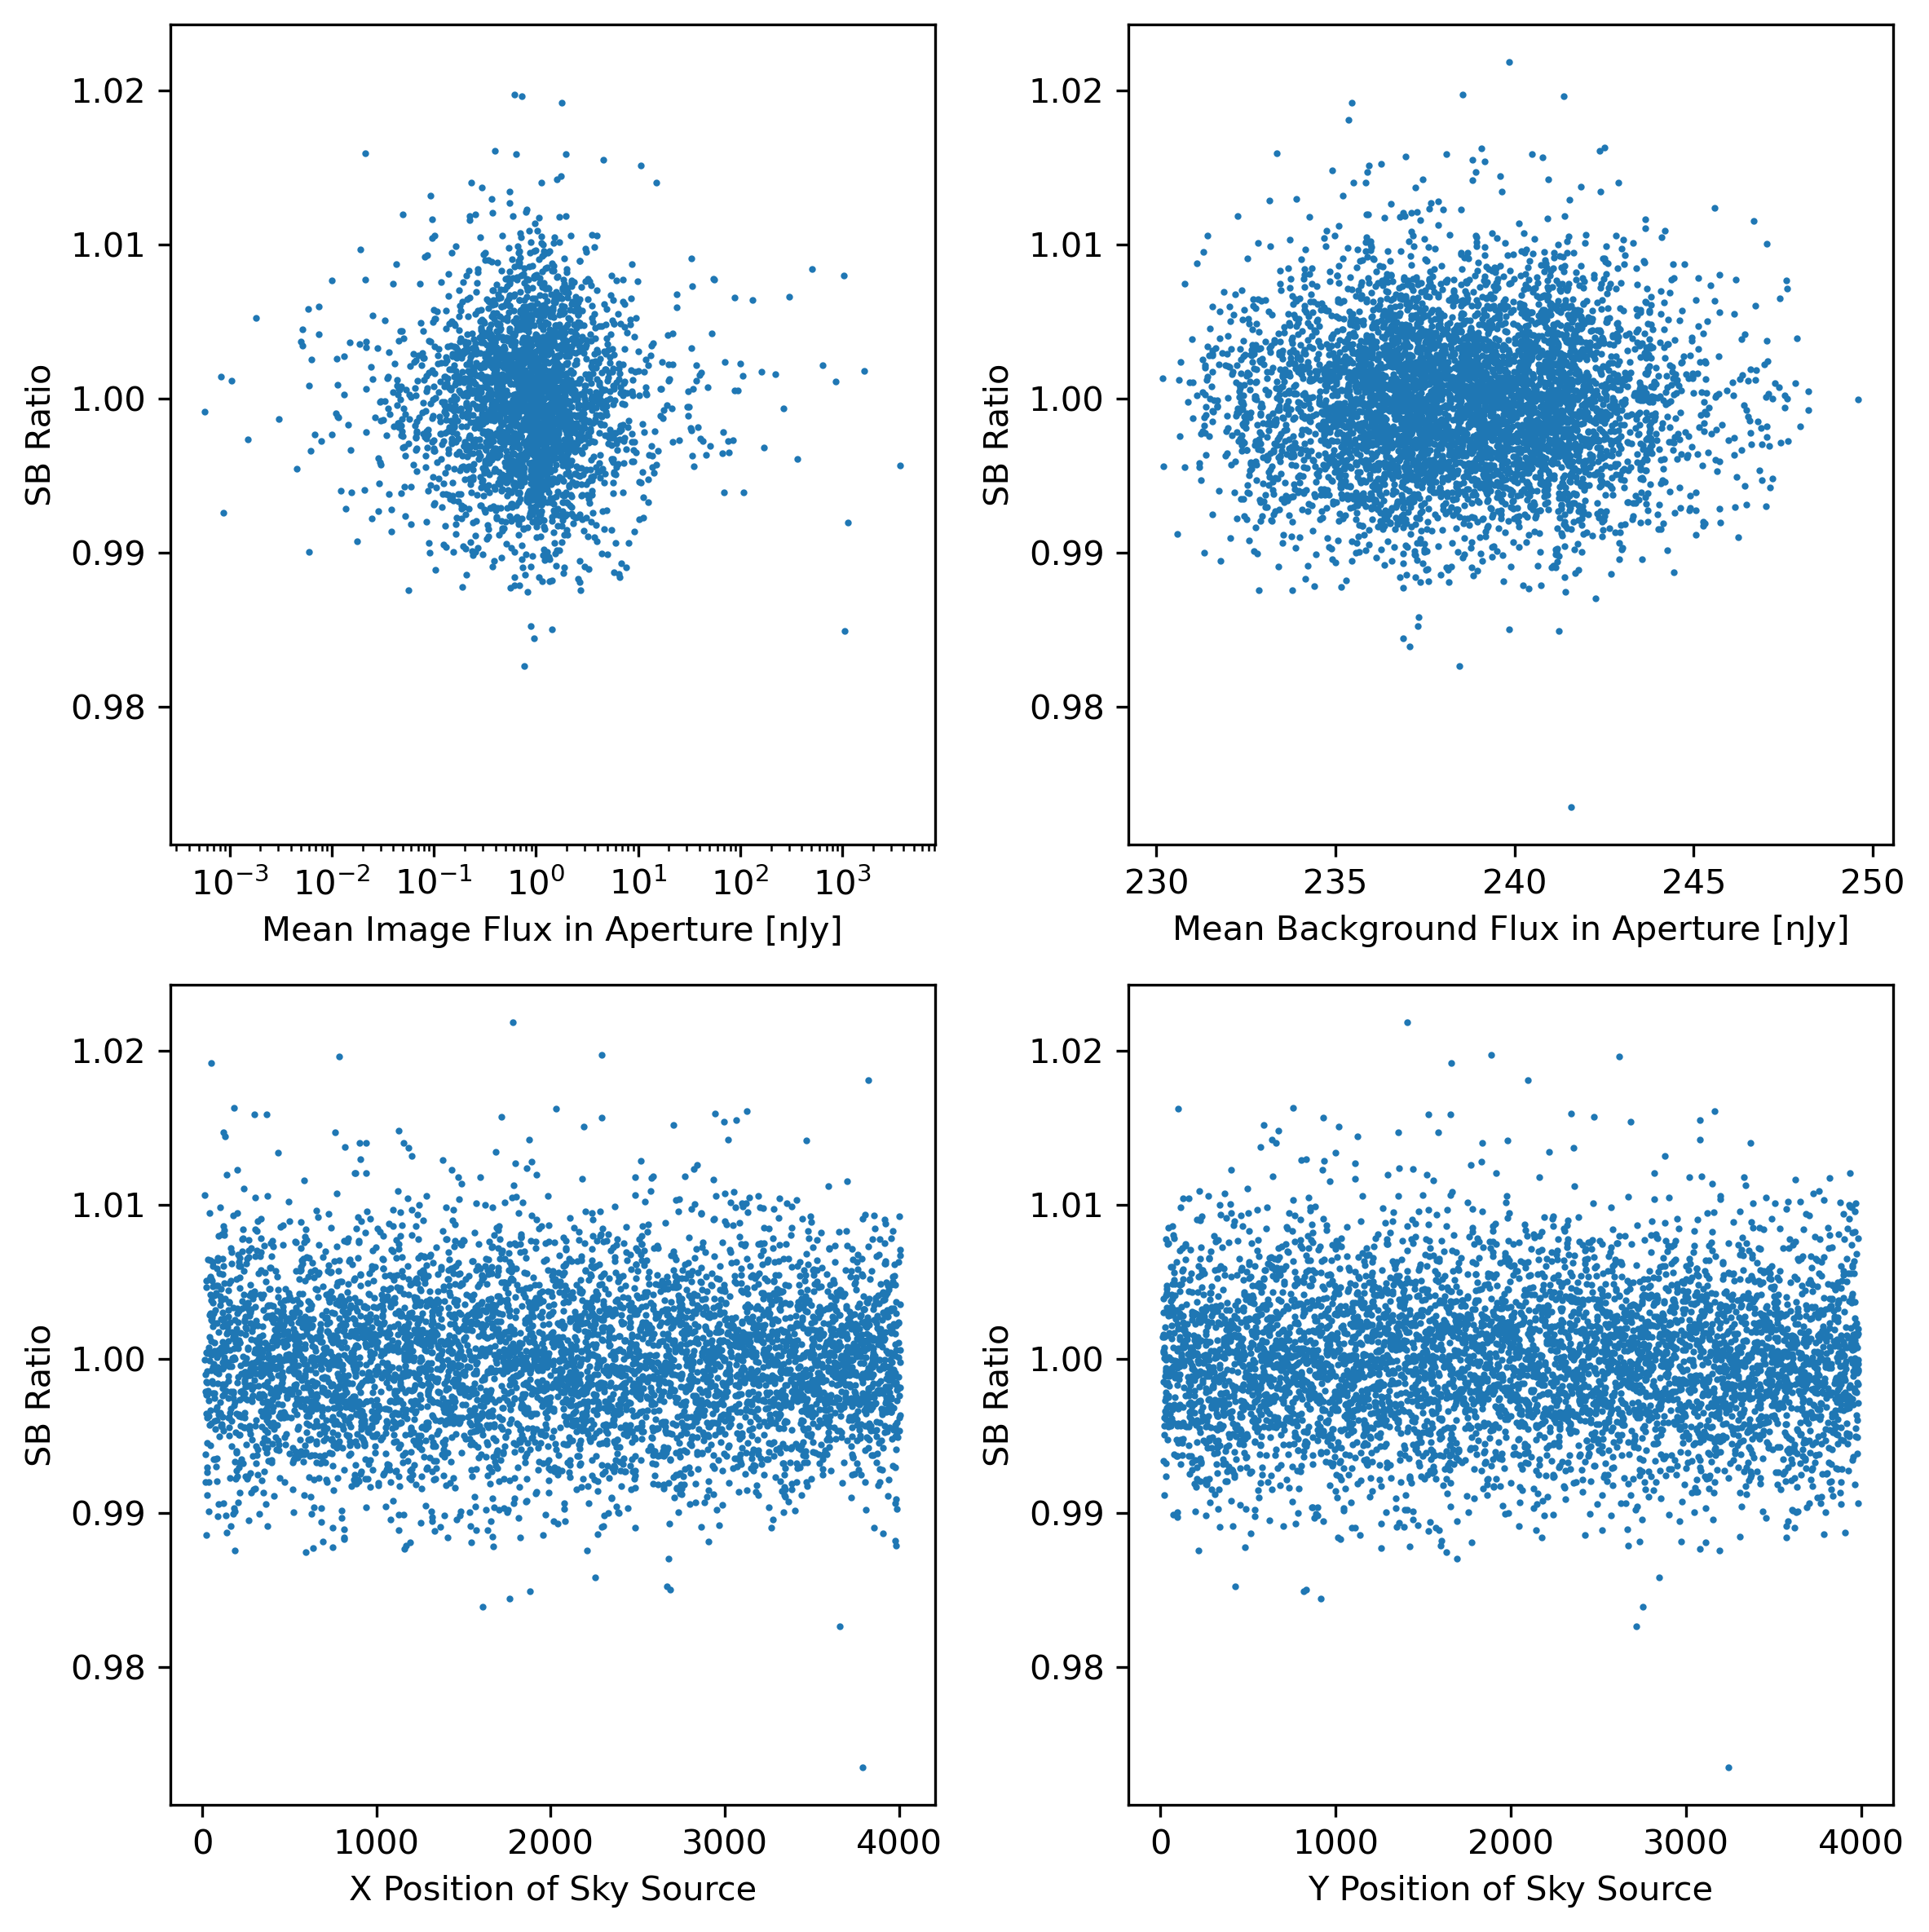

In [15]:
def plotCorrelation(resultList):
    """Plot the correlation between the image flux and SB ratio"""
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
    allMeanImageFluxInAper = np.concatenate(
        [np.concatenate(res["meanImageFluxInAper"]) for res in resultList]
    )
    allMeanBackgroundInAper = np.concatenate(
        [np.concatenate(res["meanBackgroundInAper"]) for res in resultList]
    )
    allxSky = np.concatenate([np.concatenate(res["xSky"]) for res in resultList])
    allySky = np.concatenate([np.concatenate(res["ySky"]) for res in resultList])

    zeroMask = allMeanBackgroundInAper == 0
    allMeanImageFluxInAper = allMeanImageFluxInAper[~zeroMask]
    allMeanBackgroundInApe = allMeanBackgroundInAper[~zeroMask]

    allxSky = allxSky[~zeroMask]
    allySky = allySky[~zeroMask]
    allSBRatio = np.concatenate([np.concatenate(res["SBRatio"]) for res in resultList])

    assert len(allMeanImageFluxInAper) == len(
        allSBRatio
    ), f"Length mismatch: {len(allMeanImageFluxInAper)} vs {len(allSBRatio)}"

    axes[0][0].scatter(allMeanImageFluxInAper, allSBRatio, s=1)
    axes[0][0].set_xlabel("Mean Image Flux in Aperture [nJy]")
    axes[0][0].set_ylabel("SB Ratio")
    axes[0][0].set_xscale("log")

    axes[0][1].scatter(allMeanBackgroundInApe, allSBRatio, s=1)
    axes[0][1].set_xlabel("Mean Background Flux in Aperture [nJy]")
    axes[0][1].set_ylabel("SB Ratio")

    axes[1][0].scatter(allxSky, allSBRatio, s=1)
    axes[1][0].set_xlabel("X Position of Sky Source")
    axes[1][0].set_ylabel("SB Ratio")
    axes[1][1].scatter(allySky, allSBRatio, s=1)
    axes[1][1].set_xlabel("Y Position of Sky Source")
    axes[1][1].set_ylabel("SB Ratio")

    highSBRatio = allSBRatio > 1.5
    print(f"High SB Ratio: {np.sum(highSBRatio)/len(allSBRatio)}")

    plt.tight_layout()
    plt.show()


plotCorrelation(resultList)

#### Conclusion

To be deemed a success, the requirement for LSR-REQ-0093-V-07 and OSS-REQ-0387-V-05 states that the sky brightness determination shall have a precision of 1 percent.
In this notebook, we have extracted the flux at positions on the sky that are not associated with any detected objects and compared these values to the background model produced by the LSST Science Pipelines.

We find that the maximum error in the precision of the sky brightness determination is less than 1 percent in ~97% of samples taken on real ComCam data.
As such, **we conclude that the requirement has been met**.
